# Centrography of Point Patterns

**Authors: Serge Rey <sjsrey@gmail.com> and Wei Kang <wkang12@asu.edu>**

## Introduction

Centrography refers to a set of descriptive statistics that provide summary descriptions of point patterns.

This notebook introduces three types of centrography analysis for point patterns in pysal.
* [Central Tendency](#Central-Tendency)
* [Dispersion and Orientation](#Dispersion-and-Orientation)
* [Shape Analysis](#Shape-Analysis)

We also illustrate centrography analysis using two simulated datasets. See [Another Example](#Another-Example)

The python file **centrography.py** contains several functions with which we can conduct centrography analysis.
* Central Tendency
    1. mean_center: calculate the mean center of the unmarked point pattern.
    2. weighted_mean_center: calculate the weighted mean center of the marked point pattern.
    3. manhattan_median: calculate the manhattan median
    4. euclidean_median: calculate the Euclidean median
* Dispersion and Orientation
    1. std_distance: calculate the standard distance
* Shape Analysis
    1. hull: calculate the convex hull of the point pattern
    2. mbr: calculate the minimum bounding box (rectangle)
    
All of the above functions operate on a series of coordinate pairs. That is, the data type of the first argument should be $(n,2)$ array_like. In case that you have a point pattern (PointPattern instance), you need to pass its attribute "points" instead of itself to these functions.

In [1]:
import numpy as np
from pointpattern import PointPattern
%matplotlib inline
import matplotlib.pyplot as plt
points = [[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
          [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
          [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
          [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]]
pp = PointPattern(points) #create a point pattern "pp" from list
pp.points 

,x,y
0,66.22,32.54
1,22.52,22.39
2,31.01,81.21
3,9.47,31.02
4,30.78,60.10
5,75.21,58.93
6,79.26,7.68
7,8.23,39.93
8,98.73,77.17
9,89.78,42.53


In [5]:
type(pp.points)

pandas.core.frame.DataFrame

We can use PointPattern class method **plot** to visualize **pp**.

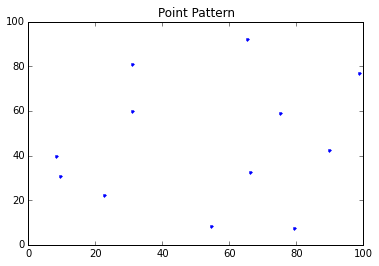

In [6]:
pp.plot()

In [7]:
#import centragraphy analysis functions 
from centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse

## Central Tendency

Central Tendency concerns about the center point of the two-dimensional distribution. It is similar to the first moment of a one-dimensional distribution. There are several ways to measure central tendency, each having pros and cons. We need to carefully select the appropriate measure according to our objective and data status.

### Mean Center $(x_{mc},y_{mc})$

$$x_{mc}=\frac{1}{n} \sum^n_{i=1}x_i$$
$$y_{mc}=\frac{1}{n} \sum^n_{i=1}y_i$$

In [8]:
mc = mean_center(pp.points)
mc

array([ 52.57166667,  46.17166667])

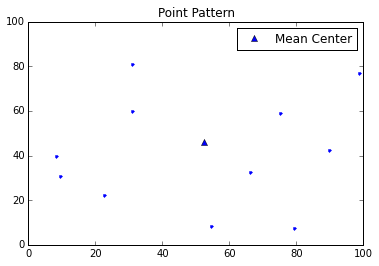

In [9]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)

### Weighted Mean Center $(x_{wmc},y_{wmc})$

$$x_{wmc}=\sum^n_{i=1} \frac{w_i x_i}{\sum^n_{i=1}w_i}$$
$$y_{wmc}=\sum^n_{i=1} \frac{w_i y_i}{\sum^n_{i=1}w_i}$$

Weighted mean center is meant for marked point patterns. Aside from the first argument which is a seris of $(x,y)$ coordinates in **weighted_mean_center** function, we need to specify its second argument which is the weight for each event point.

In [10]:
weights = np.arange(12)
weights

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [11]:
wmc = weighted_mean_center(pp.points, weights)
wmc

array([ 60.51681818,  47.76848485])

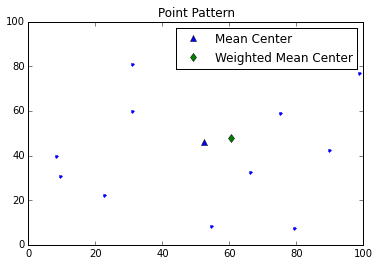

In [12]:
pp.plot() #use class method "plot" to visualize point pattern
plt.plot(mc[0], mc[1], 'b^', label='Mean Center') 
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.legend(numpoints=1)

### Manhattan Median $(x_{mm},y_{mm})$

$$min  f(x_{mm},y_{mm})= \sum^n_{i=1}(|x_i-x_{mm}|+|y_i-y_{mm}|)$$

Manhattan median is the location which minimized the absolute distance to all the event points. It is an extension of the median measure in one-dimensional space to two-dimensional space. Since in one-dimensional space, a median is the number separating the higher half of a dataset from the lower half, we define the Manhattan median as a tuple whose first element is the median of $x$ coordinates and second element is the median of $y$ coordinates.

Though Manhattan median can be found very quickly, it is not unique if you have even number of points. In this case, pysal handle the Manhattan median the same way as numpy.median: return the average of the two middle values.

In [13]:
#get the number of points in point pattern "pp"
pp.n

12

In [14]:
#Manhattan Median is not unique for "pp"
mm = manhattan_median(pp.points)
mm

centrography.py:142: UserWarning: Manhattan Median is not unique for even point patterns.
  warnings.warn(s)


array([ 59.825,  41.23 ])

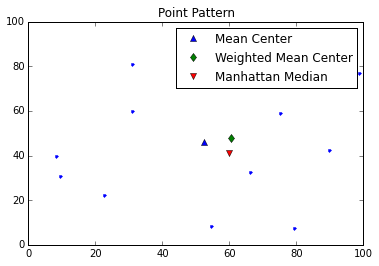

In [15]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.legend(numpoints=1)

### Euclidean Median $(x_{em},y_{em})$

$$min  f(x_{em},y_{em})= \sum^n_{i=1} \sqrt{(x_i-x_{em})^2+(y_i-y_{em})^2}$$

Euclidean Median is the location from which the sum of the Euclidean distances to all points in a distribution is a minimum. It is an optimization problem and very important for more general location allocation problems. There is no closed form solution. We can use first iterative algorithm (Kuhn and Kuenne, 1962) to approximate Euclidean Median. 

Below, we define a function named median_center with the first argument **points** a series of $(x,y)$ coordinates and the second argument **crit** the convergence criterion.

In [16]:
def median_center(points, crit=0.0001):
    points = np.asarray(points)
    x0, y0 = points.mean(axis=0)
    dx = np.inf
    dy = np.inf
    iteration = 0
    while np.abs(dx) > crit or np.abs(dy) > crit:
        xd = points[:, 0] - x0
        yd = points[:, 1] - y0
        d = np.sqrt(xd*xd + yd*yd)
        w = 1./d
        w = w / w.sum()
        x1 = w * points[:, 0]
        x1 = x1.sum()
        y1 = w * points[:, 1]
        y1 = y1.sum()
        dx = x1 - x0
        dy = y1 - y0
        iteration +=1 
        print x0, x1, dx, dy, d.sum(), iteration
        x0 = x1
        y0 = y1
               
    return x1, y1

In [17]:
median_center(pp.points, crit=.0001)

52.5716666667 53.1781282806 0.606461613936 -0.929035428634 466.244790744 1
53.1781282806 53.5664362446 0.388307964033 -0.419940265398 465.931116056 2
53.5664362446 53.8072037681 0.240767523432 -0.197486219039 465.845558673 3
53.8072037681 53.9534807621 0.14627699401 -0.09642613787 465.819775015 4
53.9534807621 54.0411725707 0.0876918085847 -0.048722506469 465.8115372 5
54.0411725707 54.0932772693 0.0521046986184 -0.0253707930471 465.808823013 6
54.0932772693 54.1240512553 0.0307739859771 -0.0135522462055 465.807914901 7
54.1240512553 54.1421524877 0.0181012324364 -0.00739190209047 465.807608775 8
54.1421524877 54.1527695605 0.0106170728019 -0.00409926582987 465.807505203 9
54.1527695605 54.1589846796 0.00621511907419 -0.00230269980711 465.807470099 10
54.1589846796 54.1626179625 0.00363328291057 -0.00130618531794 465.807458191 11
54.1626179625 54.1647398947 0.00212193220154 -0.000746340418374 465.807454149 12
54.1647398947 54.1659783195 0.00123842476709 -0.000428751015953 465.807452778

(54.167594287646125, 44.424308658832047)

After 18 iterations, the convergence criterion is reached. The Euclidean Median is $(54.167594287646125,44.424308658832047)$.

We can also call the function **euclidean_median** in pysal to calculate the Euclidean Median.

In [18]:
em = euclidean_median(pp.points)
em

array([ 54.16770671,  44.4242589 ])

The two results we get from **euclidean_median** function in pysal and the **median_center** function we define here are very much the same.

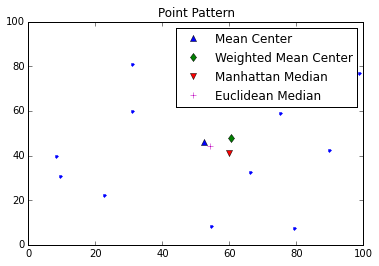

In [19]:
pp.plot()
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

## Dispersion and Orientation

### Standard Distance & Standard Distance Circle

$$SD = \displaystyle \sqrt{\frac{\sum^n_{i=1}(x_i-x_{m})^2}{n} + \frac{\sum^n_{i=1}(y_i-y_{m})^2}{n}}$$

Standard distance is obviously closely related to the usual definition of the standard deviation of a data set, and it provides a measure of how dispersed the events are around their mean center $(x_m,y_m)$.  Taken together, these measurements can be used to plot a summary circle (standard distance circle) for the point pattern, centered at $(x_m,y_m)$ with radius $SD$, as shown below.

In [20]:
stdd = std_distance(pp.points)
stdd

40.149806489086707

Plot mean center as well as the standard distance circle.

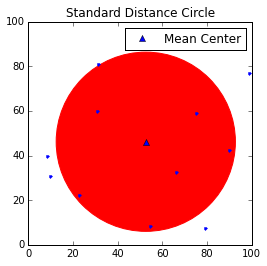

In [21]:
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r')
ax = pp.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.set_aspect('equal')
plt.legend(numpoints=1)

From the above figure, we can observe that there are five points outside the standard distance circle which are potential outliers.

## Standard Deviational Ellipse

Compared with standard distance circle which measures dispersion using a single parameter $SD$, standard deviational ellipse measures dispersion and trend in two dimensions through angle of rotation $\theta$, dispersion along major axis $s_x$ and dispersion along minor axis $s_y$:

* Major axis defines the direction of maximum spread in the distribution. $s_x$ is the semi-major axis (half the length of the major axis):

$$ s_x = \displaystyle \sqrt{\frac{2(\sum_{i=1}^n (x_i-\bar{x})\cos(\theta) - \sum_{i=1}^n (y_i-\bar{y})\sin(\theta))^2}{n-2}}$$

* Minor axis defines the direction of minimum spread and is orthogonal to major axis. $s_y$ is the semi-minor axis (half the length of the minor axis):

$$ s_y = \displaystyle \sqrt{\frac{2(\sum_{i=1}^n (x_i-\bar{x})\sin(\theta) - \sum_{i=1}^n (y_i-\bar{y})\cos(\theta))^2}{n-2}}$$

* The ellipse is rotated clockwise through an angle $\theta$:

$$\theta = \displaystyle \arctan{\{ (\sum_i(x_i-\bar{x})^2-\sum_i(y_i-\bar{y})^2) + \frac{[(\sum_i(x_i-\bar{x})^2-\sum_i(y_i-\bar{y})^2)^2 + 4(\sum_i(x-\bar{x})(y_i-\bar{y}))^2]^\frac{1}{2}}{2\sum_i(x-\bar{x})(y_i-\bar{y})}\}}$$


In [22]:
sx, sy, theta = ellipse(pp.points)
sx, sy, theta

(39.623867886462982, 42.753818949026815, 1.1039268428650906)

In [23]:
theta_degree = np.degrees(theta) #need degree of rotation to plot the ellipse
theta_degree

63.250348987371304

The Standard Deviational Ellipse for the point pattern is rotated clockwise by $63.25^{\circ}$.

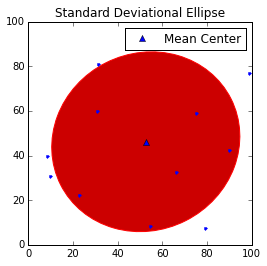

In [24]:
from matplotlib.patches import Ellipse
from pylab import figure, show,rand
fig = figure()
#ax = fig.add_subplot(111, aspect='equal')
e = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle=-theta_degree) #angle is rotation in degrees (anti-clockwise)
ax = pp.plot(get_ax=True, title='Standard Deviational Ellipse')
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_facecolor([0.8,0,0])
e.set_edgecolor([1,0,0])
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_aspect('equal')
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.legend(numpoints=1)
show()

## Shape Analysis

### [Convex Hull](https://en.wikipedia.org/wiki/Convex_hull)

Convex hull of a point pattern *pp* is the smallest convex set that contains *pp*. We can call function **hull** to caculate the convex hull.

In [25]:
hull(pp.points)

array([[ 31.01,  81.21],
       [  8.23,  39.93],
       [  9.47,  31.02],
       [ 22.52,  22.39],
       [ 54.46,   8.48],
       [ 79.26,   7.68],
       [ 89.78,  42.53],
       [ 98.73,  77.17],
       [ 65.19,  92.08]])

By specifying "hull" argument **True** in PointPattern class method **plot**, we can easily plot convex hull of the point pattern.

/Users/weikang/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


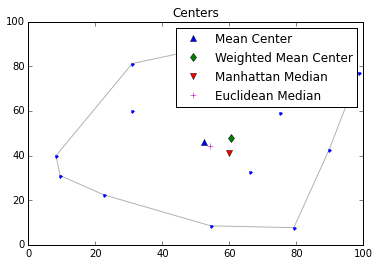

In [26]:
pp.plot(title='Centers', hull=True ) #plot point pattern "pp" as well as its convex hull
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

### [Minimum Bounding Rectangle](https://en.wikipedia.org/wiki/Minimum_bounding_rectangle)

Minimum Bounding Rectangle (Box) is the same as the minimum bounding Rectangle of its convex hull. Thus, it is almost always bigger than convex hull.

We can call **mbr** function to calculate the leftmost, downmost, rightmost, and upmost value of the vertices of minimum bounding rectangle.

In [27]:
mbr(pp.points)

(8.2300000000000004,
 7.6799999999999997,
 98.730000000000004,
 92.079999999999998)

Thus, four vertices of the  minimum bounding rectangle is $(8.23,7.68),(98.73,7.68),(98.73,92.08),(8.23,92.08)$.

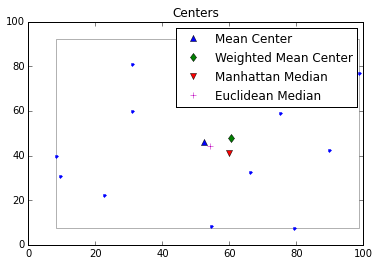

In [28]:
pp.plot(title='Centers', window=True ) #plot point pattern "pp" as well as its Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

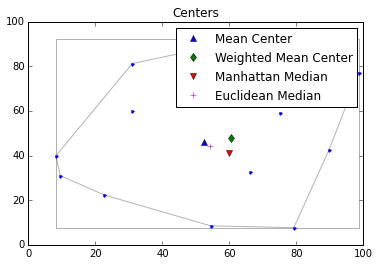

In [29]:
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
plt.plot(wmc[0], wmc[1], 'gd', label='Weighted Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

Plot Standard Distance Circle and Convex Hull.

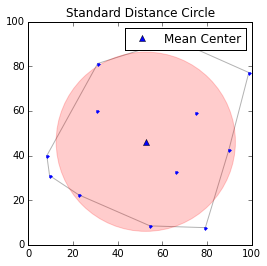

In [30]:
circle1=plt.Circle((mc[0], mc[1]),stdd,color='r',alpha=0.2)
ax = pp.plot(get_ax=True, title='Standard Distance Circle', hull=True)
ax.add_artist(circle1)
plt.plot(mc[0], mc[1], 'b^', label='Mean Center')
ax.set_aspect('equal')
plt.legend(numpoints=1)

## Another Example

We apply the above centragraphy statistics and visualization to 2 simulated randome datasets.

In [31]:
from pysal.contrib import shapely_ext
from process import PoissonPointProcess as csr
import pysal as ps
from window import as_window

# open "vautm17n" polygon shapefile
va = ps.open(ps.examples.get_path("vautm17n.shp"))

# Create the exterior polygons for VA from the union of the county shapes
polys = [shp for shp in va]
state = shapely_ext.cascaded_union(polys)

#### Simulate a 100-point dataset within VA state border from a CSR (complete spatial randomness) process.

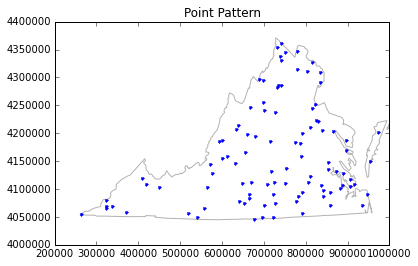

In [32]:
pp = csr(as_window(state), 100, 1, asPP=True).realizations[0]
pp.plot(window=True)

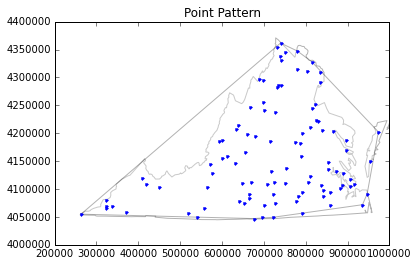

In [33]:
pp.plot(window=True, hull=True)

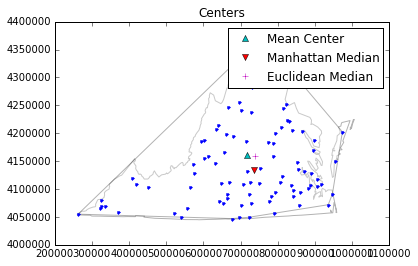

In [41]:
mc = mean_center(pp.points)
mm = manhattan_median(pp.points)
em = euclidean_median(pp.points)
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

Plot Standard Distance Circle of the simulated point pattern.

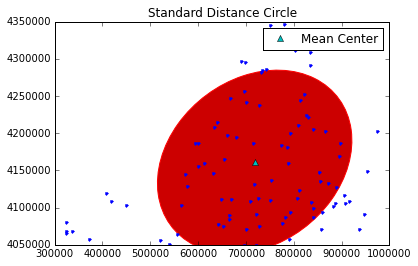

In [43]:
sx, sy, theta = ellipse(pp.points)
sx, sy, theta
theta_degree = np.degrees(theta) #need degree of rotation to plot the ellipse
from matplotlib.patches import Ellipse
from pylab import figure, show,rand
fig = figure()
#ax = fig.add_subplot(111, aspect='equal')
e = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle=-theta_degree)
ax = pp.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_facecolor([0.8,0,0])
e.set_edgecolor([1,0,0])
ax.set_xlim(300000,1000000)
ax.set_ylim(4050000,4350000)
#ax.set_aspect('equal')
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.legend(numpoints=1)
show()

#### Simulate a 500-point dataset within VA state border from a CSR (complete spatial randomness) process.

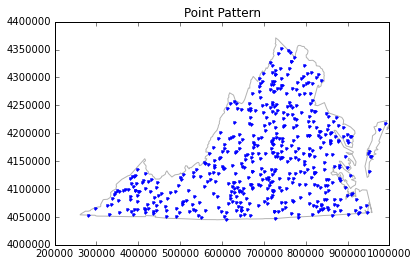

In [44]:
pp = csr(as_window(state), 500, 1, asPP=True).realizations[0]
pp.plot(window=True)

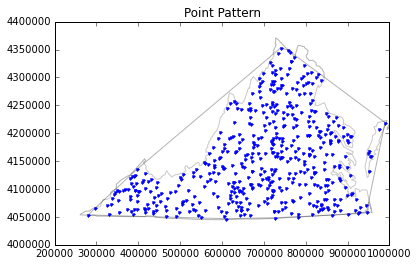

In [45]:
pp.plot(window=True, hull=True)

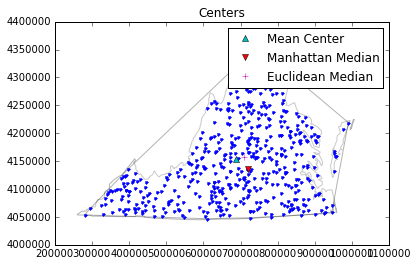

In [46]:
mc = mean_center(pp.points)
mm = manhattan_median(pp.points)
em = euclidean_median(pp.points)
pp.plot(title='Centers',  hull=True , window=True )#plot point pattern "pp", convex hull, and Minimum Bounding Rectangle
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.plot(mm[0], mm[1], 'rv', label='Manhattan Median')
plt.plot(em[0], em[1], 'm+', label='Euclidean Median')
plt.legend(numpoints=1)

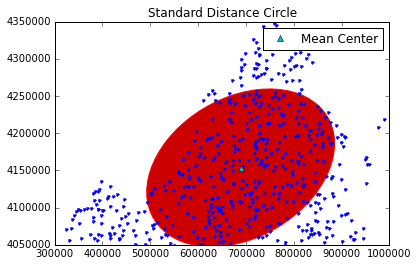

In [47]:
sx, sy, theta = ellipse(pp.points)
sx, sy, theta
theta_degree = np.degrees(theta) #need degree of rotation to plot the ellipse
from matplotlib.patches import Ellipse
from pylab import figure, show,rand
fig = figure()
#ax = fig.add_subplot(111, aspect='equal')
e = Ellipse(xy=mean_center(pp.points), width=sx*2, height=sy*2, angle=-theta_degree)
ax = pp.plot(get_ax=True, title='Standard Distance Circle')
ax.add_artist(e)
e.set_clip_box(ax.bbox)
e.set_facecolor([0.8,0,0])
e.set_edgecolor([1,0,0])
ax.set_xlim(300000,1000000)
ax.set_ylim(4050000,4350000)
#ax.set_aspect('equal')
plt.plot(mc[0], mc[1], 'c^', label='Mean Center')
plt.legend(numpoints=1)
show()

If we calculate the Euclidean distances between every event point and Mean Center (Euclidean Median), and sum them up, we can prove that Euclidean Median is the optimal point in iterms of minimizing the Euclidean distances to all the event points.

In [48]:
from centrography import dtot
print dtot(mc, pp.points)
print dtot(em, pp.points)
print dtot(mc, pp.points) > dtot(em, pp.points)

73254883.1135
72819916.2445
True
